In [1]:
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from itertools import combinations

In [4]:
strain_genotypes = {l.split()[0].strip():l.split()[1].strip() for l in open('../../data/titer-model/strain_genotypes.tsv') }
titer_tree = bt.loadJSON('../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json', {'name': 'strain', 'height': 'xvalue'})
# genotype_tree = bt.loadNexus('../../data/titer-model/titer-model-comparison_gtAnnotated_tree.nexus', absoluteTime=False)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [5]:
genotype_tips = defaultdict(list)
for k in titer_tree.leaves:
    if k.traits['strain'] in strain_genotypes:
        k.traits['genotype'] = strain_genotypes[k.traits['strain']]
        genotype_tips[k.traits['genotype']].append(k)

In [6]:
serotype_tips = { sero: [k for k in titer_tree.leaves if k.numName.startswith(sero)]
                for sero in ['DENV1', 'DENV2', 'DENV3', 'DENV4']}
serotype_mrcas = { sero: titer_tree.commonAncestor(tips, numName=True) for sero, tips in serotype_tips.items()}

In [7]:
def trace_between(k1, k2):
    '''Naive path tracing; finds mrca of the two nodes, 
    traces each node backwards until it finds the mrca, 
    returns concatenated list of all nodes on that path'''
    
    k1_trace = []
    k2_trace = []
    
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
        
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else:
#         node2_trace.append(k) # do not include mrca in trace
        mrca = k
        
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
    total_trace = []
    total_trace += shared_k1_trace
    total_trace += k2_trace
    
    return total_trace
    
def collect_attr(trace, attr='dTiter'):
    '''Collects all values of the passed attribute found 
    along the passed path through the tree'''
    return [i.traits[attr] for i in trace]

In [8]:
genotype_mrcas = { gt : titer_tree.commonAncestor(tips, numName=True) for gt, tips in genotype_tips.items() } # MRCA of each genotype
genotype_combinations = [g for g in combinations(genotype_mrcas.keys(), 2)] # Pairs of genotypes

between_genotypes = { (g1,g2): trace_between(genotype_mrcas[g1], genotype_mrcas[g2]) # Path between each pair of genotype MRCAs
                     for (g1,g2) in genotype_combinations}
genotype_dTiter = { gt: sum(collect_attr(between_genotypes[gt])) for gt in genotype_combinations}
genotype_distance = { gt: sum([ k.length for k in between_genotypes[gt]]) for gt in genotype_combinations}

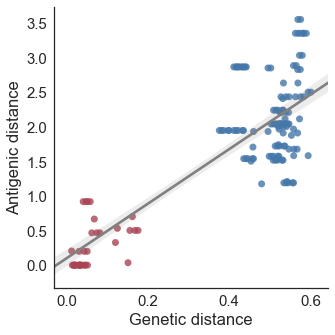

In [10]:
sns.set(style='white', font_scale=1.5)
same_serotype = { gt: gt[0].split('_')[0] == gt[1].split('_')[0] for gt in genotype_combinations}
sanity_check = pd.DataFrame({'distance': genotype_distance, 'dTiter': genotype_dTiter, 'homotypic': same_serotype})
sns.lmplot('distance', 'dTiter', 
           scatter_kws={'color': ['#aa4455' if i==True else '#4477AA' for i in sanity_check['homotypic'].values]},
           line_kws={'color': 'gray'}, data=sanity_check)

plt.xlabel('Genetic distance')
plt.ylabel('Antigenic distance')
plt.savefig('../../slides/epidemics2017/figures/png/genetic_vs_antigenic_distance.png', dpi=400, bbox_inches='tight')


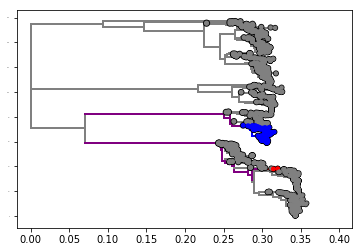

In [8]:
def plot_tree(tree):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        
        if 'on_path' in k.traits:
            c = 'purple'
        elif 'g1' in k.traits:
            c = 'blue'
        elif 'g2' in k.traits:
            c = 'red'
        else:
            c = 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))

    
### Sanity check that we drew our paths correctly between each pair of genotypes
gt, path_check = between_genotypes.items()[0]

for k in path_check:
    k.traits['on_path'] = True
    
g1 = titer_tree.traverse_tree(genotype_mrcas[gt[0]], include_all=True)
g2 = titer_tree.traverse_tree(genotype_mrcas[gt[1]], include_all=True)

for k in g1:
    k.traits['g1'] = True
for k in g2:
    k.traits['g2'] = True
    
plot_tree(titer_tree)

In [9]:
def dtiter_within(mrca, tree=titer_tree):
    
    tips = tree.traverse_tree(mrca)
    tip_combinations = [i for i in combinations(tips, 2)]
    
    dTiters = []
    
    for (t1, t2) in tip_combinations:
        dTiter = sum( collect_attr(trace_between(t1, t2)) )
        dTiters.append(dTiter)
    
    return dTiters

within_genotype_dtiters = { gt: dtiter_within(mrca) for gt, mrca in genotype_mrcas.items()}  
within_serotype_dtiters = { sero: dtiter_within(mrca) for sero, mrca in serotype_mrcas.items()}


In [8]:
serotype_combinations = [s for s in combinations(serotype_mrcas.keys(), 2)]
between_serotypes = {(s1,s2): trace_between(serotype_mrcas[s1], serotype_mrcas[s2]) 
                     for (s1, s2) in serotype_combinations}
serotype_dTiter = {s: sum(collect_attr(between_serotypes[s])) for s in serotype_combinations}

In [10]:
serotype_dTiter = pd.Series(serotype_dTiter)
print serotype_dTiter

DENV2  DENV1    1.219231
       DENV3    1.170133
DENV3  DENV1    1.099718
DENV4  DENV1    0.829299
       DENV2    0.899714
       DENV3    0.780201
dtype: float64


In [11]:
compare = {'between_serotype': serotype_dTiter.values(),
          'between_genotype': genotype_dTiter.values()}
flat_within_serotype = []
for s in within_serotype_dtiters.values():
    flat_within_serotype += s
flat_within_genotype = []
for g in within_genotype_dtiters.values():
    flat_within_genotype += g
compare['within_serotype'] = flat_within_serotype
compare['within_genotype'] = flat_within_genotype

In [14]:
compare = { k: pd.Series(v) for k,v in compare.items()}

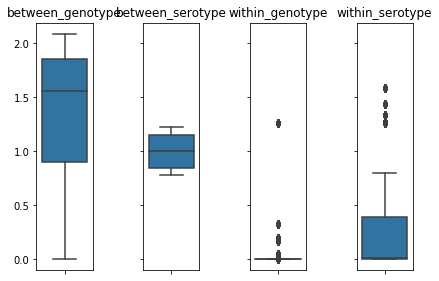

In [18]:
fig, axes = plt.subplots(1,4, sharey=True)
for i, (dataset, vals) in enumerate(sorted(compare.items())):
    ax = axes[i]
    sns.boxplot(vals, ax=ax, orient='v')
    ax.set_title(dataset)
    
plt.tight_layout()
    

In [ ]:
genotype_dTiter = pd.Series(genotype_dTiter)
genotype_dTiter = genotype_dTiter.reset_index()
genotype_dTiter.to_csv('../../data/katzelnick2015/processed/genotypes_dTiters.csv')